In [ ]:
!pip install tensorflow
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import sklearn
import imutils
from imutils import paths
import tensorflow as tf
from keras import activations

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score


In [ ]:
dataset = "/content/drive/MyDrive/FaceMaskClassifier/Dataset"
imagePaths=list(paths.list_images(dataset))

In [ ]:
data = []
labels = []

for i in imagePaths:
  label = i.split(os.path.sep)[-2]
  labels.append(label)
  image = load_img(i,target_size=(224,224))
  image = img_to_array(image)
  image = preprocess_input(image)
  data.append(image)

In [ ]:
data = np.array(data,dtype='float32')
labels=np.array(labels)

In [ ]:
data.shape

(6116, 224, 224, 3)

In [ ]:
labels

array(['with_mask', 'with_mask', 'with_mask', ..., 'without_mask',
       'without_mask', 'without_mask'], dtype='<U12')

In [ ]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [ ]:
labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [ ]:
train_X, test_X, train_Y, test_Y = train_test_split(data, labels, test_size = 0.20, random_state = 10, stratify= labels )

In [ ]:
train_X.shape

(4892, 224, 224, 3)

In [ ]:
train_Y.shape

(4892, 2)

In [ ]:
test_X.shape

(1224, 224, 224, 3)

In [ ]:
test_Y.shape

(1224, 2)

In [ ]:
data_aug = ImageDataGenerator(rotation_range=20,
                         zoom_range=0.15,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         shear_range=0.15,
                         horizontal_flip=True, 
                         vertical_flip=True,
                         fill_mode='nearest')

In [ ]:
MobileNetV2_Model = MobileNetV2(weights = 'imagenet', include_top=False,input_tensor=Input(shape=(224,224,3)))

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
Model_1 = MobileNetV2_Model.output
Model_1 = AveragePooling2D(pool_size = (7,7))(Model_1)
Model_1 = Flatten(name='Flatten')(Model_1)
Model_1 = Dense(128,activation = 'relu')(Model_1)
Model_1 = Dropout(0.5)(Model_1)
Model_1 = Dense(2, activation='softmax')(Model_1)

model_1 = Model(inputs = MobileNetV2_Model.input, outputs = Model_1)

In [ ]:
for layer in MobileNetV2_Model.layers:
  layer.trainable = False

In [ ]:
learning_rate = 0.001
Epochs = 10
BS = 12

opt = Adam(lr = learning_rate, decay = learning_rate/Epochs)
model_1.compile(loss='binary_crossentropy',optimizer = opt, metrics=['accuracy'])

History_model_1 = model_1.fit(
    data_aug.flow(train_X,train_Y,batch_size=BS),
    steps_per_epoch = len(train_X)//BS,
    validation_data = (test_X,test_Y),
    validation_steps = len(test_X)//BS,
    epochs = Epochs
)

model_1.save(r'/content/drive/MyDrive/Model/mobilenetv2.model')


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
407/407 [==============================] - 206s 496ms/step - loss: 0.1889 - accuracy: 0.9256 - val_loss: 0.0794 - val_accuracy: 0.9673
Epoch 2/10
407/407 [==============================] - 204s 501ms/step - loss: 0.1253 - accuracy: 0.9539 - val_loss: 0.0642 - val_accuracy: 0.9722
Epoch 3/10
407/407 [==============================] - 205s 504ms/step - loss: 0.1149 - accuracy: 0.9570 - val_loss: 0.0693 - val_accuracy: 0.9763
Epoch 4/10
407/407 [==============================] - 207s 509ms/step - loss: 0.0978 - accuracy: 0.9615 - val_loss: 0.0556 - val_accuracy: 0.9763
Epoch 5/10
407/407 [==============================] - 201s 494ms/step - loss: 0.0963 - accuracy: 0.9650 - val_loss: 0.0604 - val_accuracy: 0.9763
Epoch 6/10
407/407 [==============================] - 201s 495ms/step - loss: 0.0950 - accuracy: 0.9674 - val_loss: 0.0560 - val_accuracy: 0.9763
Epoch 7/10
407/407 [==============================] - 202s 496ms/step - loss: 0.0813 - accuracy: 0.9672 - val_loss: 0.0576 -

In [ ]:
predict_model_1 = model_1.predict(test_X,batch_size = BS)
predict_model_1 = np.argmax(predict_model_1,axis = 1)
print(classification_report(test_Y.argmax(axis = 1), predict_model_1, target_names = lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.95      1.00      0.97       610
without_mask       1.00      0.95      0.97       614

    accuracy                           0.97      1224
   macro avg       0.97      0.97      0.97      1224
weighted avg       0.97      0.97      0.97      1224



In [ ]:
print(confusion_matrix(test_Y.argmax(axis = 1), predict_model_1))

In [ ]:
print('Accuracy:', accuracy_score(test_Y.argmax(axis = 1), predict_model_1))

Accuracy: 0.9730392156862745


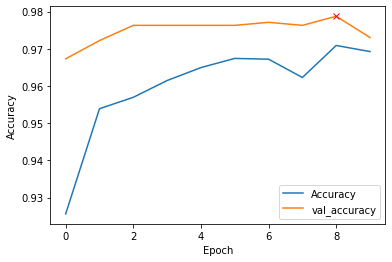

In [ ]:
accu_model_1 = History_model_1.history['accuracy']
val_acc_model_1 = History_model_1.history['val_accuracy']

plt.plot(accu_model_1, label="Accuracy")
plt.plot(val_acc_model_1)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['Accuracy', 'val_accuracy'])
plt.plot(np.argmax(History_model_1.history["val_accuracy"]), np.max(History_model_1.history["val_accuracy"]), marker="x", color="r",
         label="best model")
plt.show()

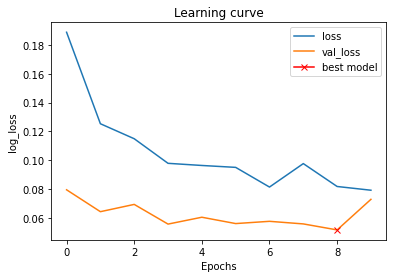

In [ ]:
plt.title("Learning curve")
plt.plot(History_model_1.history["loss"], label="loss")
plt.plot(History_model_1.history["val_loss"], label="val_loss")
plt.plot(np.argmin(History_model_1.history["val_loss"]), np.min(History_model_1.history["val_loss"]), marker="x", color="r",
         label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

## ResNet50

In [ ]:
from keras.applications.resnet import ResNet50

In [ ]:
resnet50_model = ResNet50(weights = 'imagenet', include_top=False,input_tensor=Input(shape=(224,224,3)))

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
Model_2 = resnet50_model.output
Model_2 = AveragePooling2D(pool_size = (7,7))(Model_2)
Model_2 = Flatten(name='Flatten')(Model_2)
Model_2 = Dense(128,activation = 'relu')(Model_2)
Model_2 = Dropout(0.5)(Model_2)
Model_2 = Dense(2, activation='softmax')(Model_2)

model_2 = Model(inputs = resnet50_model.input, outputs = Model_2)

In [ ]:
for layer in resnet50_model.layers:
  layer.trainable = False

In [ ]:
learning_rate = 0.001
Epochs = 10
BS = 12

opt = Adam(learning_rate, decay = learning_rate/Epochs)
model_2.compile(optimizer = opt, loss='binary_crossentropy', metrics=['accuracy'])

History_model_2 = model_2.fit(
    data_aug.flow(train_X,train_Y,batch_size=BS),
    steps_per_epoch = len(train_X)//BS,
    validation_data = (test_X,test_Y),
    validation_steps = len(test_X)//BS,
    epochs = Epochs)

model_2.save(r'/content/drive/MyDrive/FaceMaskClassifier/ResNet50Model')

Epoch 1/10
407/407 [==============================] - 915s 2s/step - loss: 0.6912 - accuracy: 0.5471 - val_loss: 0.6414 - val_accuracy: 0.7753
Epoch 2/10
407/407 [==============================] - 921s 2s/step - loss: 0.6623 - accuracy: 0.5957 - val_loss: 0.5909 - val_accuracy: 0.7778
Epoch 3/10
407/407 [==============================] - 934s 2s/step - loss: 0.6469 - accuracy: 0.6232 - val_loss: 0.5888 - val_accuracy: 0.7958
Epoch 4/10
407/407 [==============================] - 932s 2s/step - loss: 0.6380 - accuracy: 0.6441 - val_loss: 0.5639 - val_accuracy: 0.8154
Epoch 5/10
407/407 [==============================] - 930s 2s/step - loss: 0.6320 - accuracy: 0.6504 - val_loss: 0.5592 - val_accuracy: 0.7590
Epoch 6/10
407/407 [==============================] - 943s 2s/step - loss: 0.6049 - accuracy: 0.6732 - val_loss: 0.4895 - val_accuracy: 0.8317
Epoch 7/10
407/407 [==============================] - 939s 2s/step - loss: 0.5948 - accuracy: 0.6932 - val_loss: 0.4963 - val_accuracy: 0.8448

In [ ]:
predict_model_2 = model_2.predict(test_X,batch_size = BS)
predict_model_2 = np.argmax(predict_model_2,axis = 1)
print(classification_report(test_Y.argmax(axis = 1), predict_model_2, target_names = lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.72      0.93      0.81       610
without_mask       0.90      0.65      0.75       614

    accuracy                           0.79      1224
   macro avg       0.81      0.79      0.78      1224
weighted avg       0.81      0.79      0.78      1224



In [ ]:
print(confusion_matrix(test_Y.argmax(axis = 1), predict_model_2))

[[566  44]
 [217 397]]


In [ ]:
print('Accuracy:', accuracy_score(test_Y.argmax(axis = 1), predict_model_2))

Accuracy: 0.7867647058823529


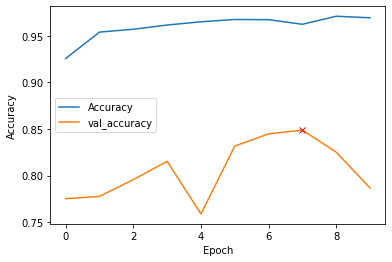

In [ ]:
accu_model_2 = History_model_2.history['accuracy']
val_acc_model_2 = History_model_2.history['val_accuracy']

plt.plot(accu_model_1, label="Accuracy")
plt.plot(val_acc_model_2)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['Accuracy', 'val_accuracy'])
plt.plot(np.argmax(History_model_2.history["val_accuracy"]), np.max(History_model_2.history["val_accuracy"]), marker="x", color="r",
         label="best model")
plt.show()

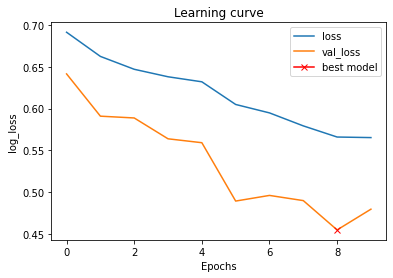

In [ ]:
plt.title("Learning curve")
plt.plot(History_model_2.history["loss"], label="loss")
plt.plot(History_model_2.history["val_loss"], label="val_loss")
plt.plot(np.argmin(History_model_2.history["val_loss"]), np.min(History_model_2.history["val_loss"]), marker="x", color="r",
         label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();